# **1.Sample**

In [1]:
# Cell 1 — Setup & Mount (Sample)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)

# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Cell 2 — Load & Peek (Sample)
PATH = "/content/drive/MyDrive/Indians_Diabetes_Dataset/diabetes.csv"  # comma-separated
df = pd.read_csv(PATH)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)

df.head(3)


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Dtypes:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [3]:
# Cell 3 — Sanity Checks (Sample; report only)
# Missing values per column (only show if any)
na_counts = df.isna().sum()
print("Missing values (non-zero only):")
print(na_counts[na_counts > 0] if na_counts.sum() > 0 else "None")

# Duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Impossible negatives in numeric columns (counts per column)
num_cols = df.select_dtypes(include=[np.number]).columns
neg_counts = (df[num_cols] < 0).sum()
print("\nNegative-value counts (non-zero only):")
print(neg_counts[neg_counts > 0] if (neg_counts > 0).any() else "None")


Missing values (non-zero only):
None

Duplicate rows: 0

Negative-value counts (non-zero only):
None


In [4]:
# Cell 4 — Define Target & Features (Sample)
assert 'Outcome' in df.columns, "Target column 'Outcome' not found. Please confirm."
y = df['Outcome'].astype(int)
X = df.drop(columns=['Outcome'])
print("X shape:", X.shape, "| y positive rate:", y.mean().round(3))


X shape: (768, 8) | y positive rate: 0.349


In [5]:
# Cell 5 — Stratified 80/10/10 Split (Sample)
# First: hold out 10% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Then: from remaining 90%, carve out ~11.111% as valid => overall 10%
valid_frac_of_full = 0.10 / 0.90
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=valid_frac_of_full, stratify=y_train_full, random_state=42
)

def brief_balance(name, yvec):
    vc = yvec.value_counts(normalize=True).sort_index()
    print(f"{name}: n={len(yvec)} | class 0={vc.get(0,0):.3f} | class 1={vc.get(1,0):.3f}")

print(f"Sizes -> train:{len(X_train)}, valid:{len(X_valid)}, test:{len(X_test)}")
brief_balance("Train", y_train)
brief_balance("Valid", y_valid)
brief_balance("Test ", y_test)


Sizes -> train:614, valid:77, test:77
Train: n=614 | class 0=0.651 | class 1=0.349
Valid: n=77 | class 0=0.649 | class 1=0.351
Test : n=77 | class 0=0.649 | class 1=0.351


# **2.Explore**

In [6]:
# Cell 1 — Explore: Class balance & imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Outcome prevalence (train):", y_train.mean().round(3))


Outcome prevalence (train): 0.349


In [7]:
# Cell 2 — Explore: Brief numeric summary (median/IQR/min/max) on train
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)
summary = pd.DataFrame({
    "min": X_train.min(),
    "median": X_train.median(),
    "IQR": (q3 - q1),
    "max": X_train.max()
}).round(2)
summary


,min,median,IQR,max
Pregnancies,0.00,3.00,5.00,17.00
Glucose,0.00,116.00,40.00,199.00
BloodPressure,0.00,72.00,16.00,122.00
SkinThickness,0.00,23.00,32.00,99.00
Insulin,0.00,41.50,126.75,846.00
BMI,0.00,32.00,8.70,57.30
DiabetesPedigreeFunction,0.08,0.38,0.40,2.33
Age,21.00,29.50,17.00,81.00


In [8]:
# Cell 3 — Explore: Implausible zero rates (saved for Modify)
implausible_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
zero_rates = {c: (X_train[c] == 0).mean().round(3) for c in implausible_zero_cols if c in X_train.columns}
print("Zero rates (train) for implausible-zero columns:", zero_rates)


Zero rates (train) for implausible-zero columns: {'Glucose': np.float64(0.008), 'BloodPressure': np.float64(0.037), 'SkinThickness': np.float64(0.282), 'Insulin': np.float64(0.479), 'BMI': np.float64(0.013)}


In [9]:
# Cell 4 — Explore: Quick signal check (|Pearson r| vs Outcome), top 5
corrs = pd.concat([X_train, y_train.rename("Outcome")], axis=1).corr(numeric_only=True)["Outcome"].drop("Outcome")
top5 = corrs.abs().sort_values(ascending=False).head(5).round(3)
top5.to_frame("abs_corr_to_Outcome")


,abs_corr_to_Outcome
Glucose,0.460
BMI,0.278
Age,0.225
Pregnancies,0.190
Insulin,0.170


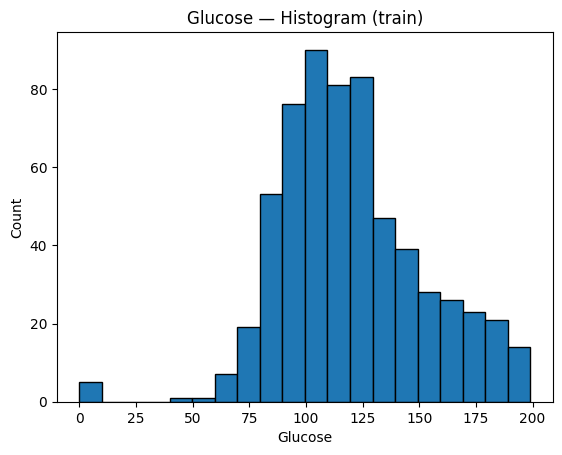

In [10]:
# Cell 5 — Explore: Histogram — Glucose (train)
plt.figure()
X_train["Glucose"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Glucose — Histogram (train)")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-1845950324.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0.dropna(), data1.dropna()], labels=["Outcome=0", "Outcome=1"])


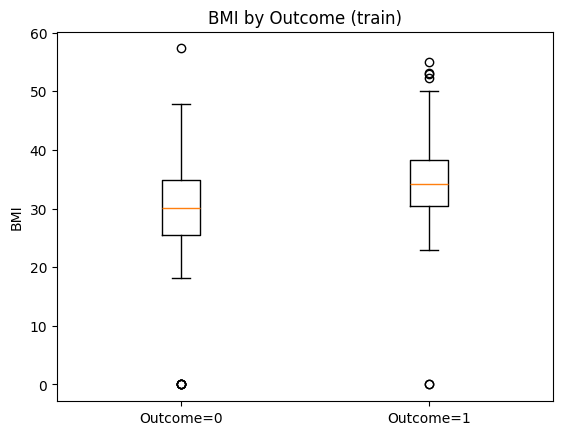

In [11]:
# Cell 6 — Explore: Boxplot — BMI by Outcome (train)
plt.figure()
data0 = X_train.loc[y_train == 0, "BMI"]
data1 = X_train.loc[y_train == 1, "BMI"]
plt.boxplot([data0.dropna(), data1.dropna()], labels=["Outcome=0", "Outcome=1"])
plt.title("BMI by Outcome (train)")
plt.ylabel("BMI")
plt.show()


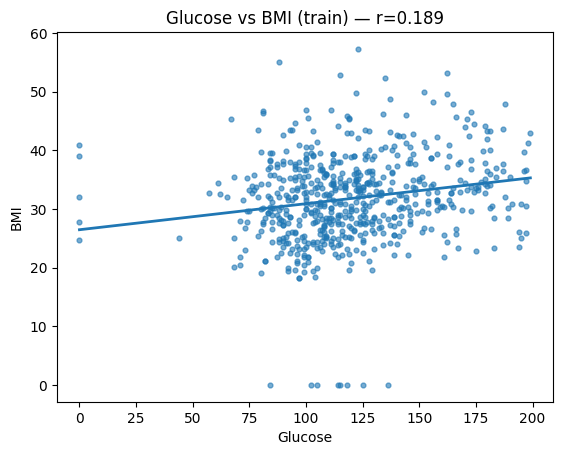

In [12]:
# Cell 7 — Explore: Scatter — Glucose vs BMI (train) with Pearson r and LS line
x = X_train["Glucose"].values
y = X_train["BMI"].values
mask = np.isfinite(x) & np.isfinite(y)
xv, yv = x[mask], y[mask]
r = np.corrcoef(xv, yv)[0, 1]
m, b = np.polyfit(xv, yv, 1)

plt.figure()
plt.scatter(xv, yv, s=12, alpha=0.6)
xs = np.array([xv.min(), xv.max()])
plt.plot(xs, m*xs + b, linewidth=2)
plt.title(f"Glucose vs BMI (train) — r={r:.3f}")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()


# **3.Modify**

In [13]:
# Cell 1 — Modify: column groups & zero→missing audit
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# Targeted columns where zero is implausible
targeted_standard_cols_all = ["Glucose", "BloodPressure", "SkinThickness"]
targeted_robust_cols_all   = ["Insulin", "BMI"]

# Keep only columns that exist in this dataset
present = set(X_train.columns)
tgt_std_cols = [c for c in targeted_standard_cols_all if c in present]
tgt_rob_cols = [c for c in targeted_robust_cols_all if c in present]

# "Other" numeric columns (exclude the five targeted ones)
numeric_cols = list(X_train.select_dtypes(include=[np.number]).columns)
other_cols = [c for c in numeric_cols if c not in (tgt_std_cols + tgt_rob_cols)]

# Zero→missing audit counts on TRAIN ONLY (for targeted columns)
zero_impute_counts = {c: int((X_train[c] == 0).sum()) for c in (tgt_std_cols + tgt_rob_cols)}
print("Zero→missing counts on TRAIN (targeted columns):", zero_impute_counts)


Zero→missing counts on TRAIN (targeted columns): {'Glucose': 5, 'BloodPressure': 23, 'SkinThickness': 173, 'Insulin': 294, 'BMI': 8}


In [15]:
# Cell 2 — Modify: define pipelines (zero→NaN → median impute → scale)
def zero_to_nan(X):
    # Works for DataFrame or ndarray
    X = X.copy()
    return np.where(X == 0, np.nan, X)

pipe_tgt_std = Pipeline(steps=[
    ("zero2nan", FunctionTransformer(zero_to_nan, validate=False)),
    ("imputer",  SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])

pipe_tgt_rob = Pipeline(steps=[
    ("zero2nan", FunctionTransformer(zero_to_nan, validate=False)),
    ("imputer",  SimpleImputer(strategy="median")),
    ("scaler",   RobustScaler())
])

pipe_other = Pipeline(steps=[
    ("imputer",  SimpleImputer(strategy="median")),
    ("scaler",   StandardScaler())
])

pre = ColumnTransformer(transformers=[
    ("tgt_std", pipe_tgt_std, tgt_std_cols),
    ("tgt_rob", pipe_tgt_rob, tgt_rob_cols),
    ("other",   pipe_other,   other_cols)
], remainder="drop", verbose_feature_names_out=False)


In [16]:
# Cell 3 — Modify: fit on TRAIN only; transform all splits; shape + NaN checks
pre.fit(X_train)

X_train = pre.transform(X_train)
X_valid = pre.transform(X_valid)
X_test  = pre.transform(X_test)

print("Shapes  ->", "train:", X_train.shape, "| valid:", X_valid.shape, "| test:", X_test.shape)
print("NaNs    ->", "train:", np.isnan(X_train).sum(), "| valid:", np.isnan(X_valid).sum(), "| test:", np.isnan(X_test).sum())


Shapes  -> train: (614, 8) | valid: (77, 8) | test: (77, 8)
NaNs    -> train: 0 | valid: 0 | test: 0


# **4.Model**

In [17]:
# Cell 1 — Model: imports & candidate estimators
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.base import clone

candidates = [
    ("LogReg_C0.1", LogisticRegression(C=0.1, class_weight="balanced", solver="liblinear", max_iter=1000, random_state=42)),
    ("LogReg_C1.0", LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear", max_iter=1000, random_state=42)),
    ("RF_depth5",   RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=10,
                                           class_weight="balanced", random_state=42, n_jobs=-1)),
]


In [18]:
# Cell 2 — Model: train on TRAIN, select by VALID ROC-AUC
leader = []
best_name, best_est, best_auc, best_valid_proba = None, None, -np.inf, None

for name, est in candidates:
    est.fit(X_train, y_train)
    proba = est.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, proba)
    leader.append((name, auc))
    if auc > best_auc:
        best_name, best_est, best_auc, best_valid_proba = name, est, auc, proba

leaderboard = pd.DataFrame(leader, columns=["model", "valid_auc"]).sort_values("valid_auc", ascending=False).reset_index(drop=True)
print(leaderboard)
print(f"\nSelected: {best_name} (valid AUC = {best_auc:.3f})")


         model  valid_auc
0  LogReg_C0.1   0.889630
1  LogReg_C1.0   0.888889
2    RF_depth5   0.854815

Selected: LogReg_C0.1 (valid AUC = 0.890)


In [19]:
# Cell 3 — Model: pick decision threshold on VALID by max F1
prec, rec, thr = precision_recall_curve(y_valid, best_valid_proba)
f1 = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0.0)

# precision_recall_curve returns len(thr) = len(prec) - 1; align by excluding last prec/rec when indexing thr
idx = np.argmax(f1[:-1])
best_thr = float(thr[idx])
print(f"best_thr (max F1 on valid): {best_thr:.3f}")
print(f"At best_thr: precision={prec[idx]:.3f}, recall={rec[idx]:.3f}, F1={f1[idx]:.3f}")


best_thr (max F1 on valid): 0.635
At best_thr: precision=0.778, recall=0.778, F1=0.778


In [20]:
# Cell 4 — Model: refit final_model on TRAIN+VALID with chosen hyperparams
X_trval = np.vstack([X_train, X_valid])
y_trval = pd.concat([y_train, y_valid], axis=0)

final_model = clone(best_est)
final_model.fit(X_trval, y_trval)

print(f"final_model: {final_model.__class__.__name__} (from {best_name})")
print("Train+Valid size:", X_trval.shape, "| Test size:", X_test.shape)


final_model: LogisticRegression (from LogReg_C0.1)
Train+Valid size: (691, 8) | Test size: (77, 8)


# **5.Assess**

In [21]:
# Cell 1 — Assess: Test probabilities & ROC-AUC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss

y_proba_test = final_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_proba_test)
brier = brier_score_loss(y_test, y_proba_test)

print(f"Test ROC-AUC: {auc_test:.3f}")
print(f"Brier score (test): {brier:.4f}")


Test ROC-AUC: 0.829
Brier score (test): 0.1745


In [22]:
# Cell 2 — Assess: Thresholded metrics on TEST at best_thr
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

y_pred_test = (y_proba_test >= best_thr).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)
f1 = f1_score(y_test, y_pred_test, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
bal_acc = balanced_accuracy_score(y_test, y_pred_test)

print("Confusion matrix [TN FP; FN TP]:")
print(np.array([[tn, fp], [fn, tp]]))
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
print(f"Specificity: {specificity:.3f} | Balanced Accuracy: {bal_acc:.3f}")
print(f"Decision threshold (from validation): best_thr = {best_thr:.3f}")


Confusion matrix [TN FP; FN TP]:
[[40 10]
 [11 16]]
Precision: 0.615 | Recall: 0.593 | F1: 0.604
Specificity: 0.800 | Balanced Accuracy: 0.696
Decision threshold (from validation): best_thr = 0.635


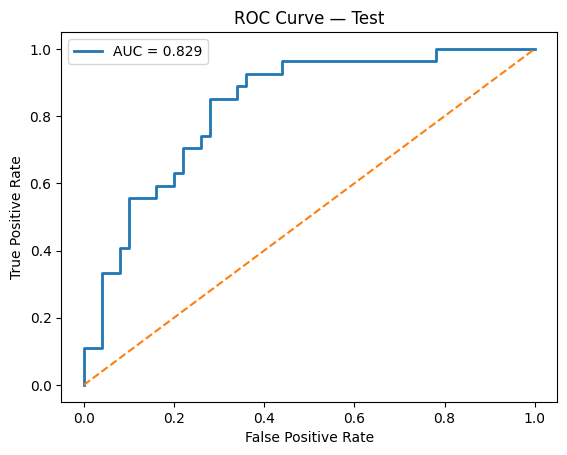

In [23]:
# Cell 3 — Assess: ROC curve (TEST)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure()
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve — Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [24]:
# Cell 4 — Assess: Top-5 features (coefficients or importances)
# Reconstruct feature names from the preprocessor
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(X_test.shape[1])])

if hasattr(final_model, "coef_"):
    coefs = final_model.coef_.ravel()
    top = (pd.DataFrame({"feature": feature_names, "value": coefs})
             .assign(abs=lambda d: d["value"].abs())
             .sort_values("abs", ascending=False)
             .head(5))
    print("Top-5 features by |coefficient| (LogisticRegression):")
    display(top[["feature", "value"]].round(4))
elif hasattr(final_model, "feature_importances_"):
    fi = final_model.feature_importances_
    top = (pd.DataFrame({"feature": feature_names, "importance": fi})
             .sort_values("importance", ascending=False)
             .head(5))
    print("Top-5 features by importance (RandomForest):")
    display(top.round(4))
else:
    print("Model does not expose coefficients or importances.")


Top-5 features by |coefficient| (LogisticRegression):


,feature,value
0,f0,1.0013
4,f4,0.6675
5,f5,0.3516
6,f6,0.2968
7,f7,0.1725
